### Code Hist.

 - CODE  
    &ensp; : Model - KIER Method 02(Clustering)

  - DATE      &ensp; 2023-03-05 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dataset : KIER / KMA_ASOS    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2) Model : LightGBM  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import math
import random

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split

# CLustering 알고리즘의 성능 평가 측도
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
# !pip install catboost

## LGBM
from catboost import Pool, CatBoostRegressor

# !pip install lightgbm

## LGBM
import lightgbm as lgbm
from lightgbm import LGBMRegressor

## LSTM
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
## Import_Local
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_Common_Data_Analysis as com_Analysis
from Src_Dev_Common import DEV_Common_Data_Preprocessing as com_Prep
from Src_Dev_Common import DEV_Common_Data_Visualization as com_Visual
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_ASOS
from Src_Dev_Common import DEV_KDHC_Usage as com_KDHC
from Src_Dev_Common import DEV_KIER_Usage as com_KIER

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-03-08 15:22:08.891980
2024 / 3 / 8
15 : 22


In [7]:
## Dict_Domain
dict_domain = {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"} ## GAS는 사용하지 않음.
int_domain = 0
str_domain = str(dict_domain[int_domain])

dict_col_accu = {0 : "ACTUAL_ACCU_EFF" ## ELEC
                 , 1 : "ACCU_HEAT" ## HEAT
                 , 2 : "ACCU_FLOW" ## WATER
                 , 3 : "ACCU_HEAT" ## HOT 열량
                 , 4 : "ACCU_FLOW" ## HOT 유량
                 , 99 : "ACCU_FLOW" ## GAS
                 }
str_col_accu = str(str_domain + "_" + str(dict_col_accu[int_domain]))

dict_col_inst = {0 : "INST_EFF" ## ELEC_ACCU/INST_EFF
                , 1 : "INST_HEAT" ## HEAT_ACCU/INST_HEAT
                , 2 : "INST_FLOW" ## WATER_ACCU/INST_FLOW
                , 3 : "INST_HEAT" ## HOT_ACCU/INST_HEAT
                , 4 : "INST_FLOW" ## HOT_ACCU/INST_FLOW
                , 99 : "INST_FLOW" ## GAS_ACCU/INST_FLOW
                } 
str_col_inst = str(str_domain + "_" + str(dict_col_inst[int_domain]))

## Directory Root
str_dirData = "../data/data_Energy_KIER/"
str_dir_raw = '../data/data_Energy_KIER/KIER_0_Raw/'
str_dirName_bld = '../data/data_Energy_KIER/KIER_1_BLD/'
str_dirName_f = '../data/data_Energy_KIER/KIER_2_F_' + str_domain + '/'
str_dirName_h = '../data/data_Energy_KIER/KIER_3_H_' + str_domain + '/'

## File
str_fileRaw = str('KIER_RAW_' + str_domain + '_2023-11-12.csv')
str_fileRaw_hList = str('KIER_hList_' + str_domain + '.csv')

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'Data_Population_SJ_2014_2018_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_D_1st_Interpolated.csv', 'Data_Population_SJ_2014_2018_H_1st_Interpolated.csv', 'DATE_1M_2023-10-20.csv', 'ENV_SENSOR_HST_202309251452.csv', 'F1_MAIN_POWER_HST_202309251503.csv', 'F1_SUB_POWER_HST_202309251510.csv', 'HEATPUMP_HST_202309251520.csv', 'KIER_0_Raw', 'KIER_1_BLD', 'KIER_2_F_ELEC', 'KIER_2_F_GAS', 'KIER_2_F_HEAT', 'KIER_2_F_HOT', 'KIER_2_F_WATER', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', 'LIGHT_HST_202309251523.csv', 'MACHINE_ROOM_HEAT_HST_202309251534.csv', 'MACHINE_ROOM_POWER_APT_HST_20221205_202309251617.csv', 'MACHINE_ROOM_POWER_APT_HST_20221205_202309

## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage (Intergrated)

In [8]:
## KMA_ASOS Data
str_dir_kmaAsos = "../data/data_KMA_ASOS/"

## Interpolate / Filled ASOS Data
str_file = 'ASOS_119_2010-2024_HR_INTP.csv'
Data_ASOS = pd.read_csv(str_dir_kmaAsos + str_file
                        , index_col = 0)
Data_ASOS['METER_DATE'] = pd.to_datetime(Data_ASOS['METER_DATE'])
Data_ASOS

,temp_outdoor,temp_dew_point,temp_ground,humidity,rainfall,snowfall,snowfall_3hr,wind_speed,wind_direction,pressure_vapor,...,solar_radiation,cloud_total,cloud_midlow,visual_range,YEAR,MONTH,DAY,HOUR,None,METER_DATE
0,-10.3000000000,-17.6000000000,-5.8000000000,55.0000000000,0.0000000000,0.5000000000,0.0000000000,1.6000000000,340.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,0,0,2010-01-01 00:00:00
1,-10.4000000000,-17.9000000000,-5.7000000000,54.0000000000,0.0000000000,0.5000000000,0.0000000000,0.3000000000,0.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2010,1,1,1,0,2010-01-01 01:00:00
2,-10.6000000000,-17.6000000000,-5.9000000000,56.0000000000,0.0000000000,0.5000000000,0.0000000000,0.6000000000,270.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,2010,1,1,2,0,2010-01-01 02:00:00
3,-11.0000000000,-18.0000000000,-5.9000000000,56.0000000000,0.0000000000,0.5000000000,0.0000000000,1.5000000000,290.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,3,0,2010-01-01 03:00:00
4,-11.6000000000,-18.2000000000,-6.0000000000,58.0000000000,0.0000000000,0.5000000000,0.0000000000,0.9000000000,290.0000000000,1.5000000000,...,0.0000000000,0.0000000000,0.0000000000,2000.0000000000,2010,1,1,4,0,2010-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8656,2.1000000000,0.3000000000,-0.3000000000,88.0000000000,0.0000000000,0.0000000000,0.0000000000,0.5000000000,270.0000000000,6.2000000000,...,0.0000000000,0.0000000000,0.0000000000,2055.0000000000,2023,12,31,19,0,2023-12-31 19:00:00
8657,1.1000000000,0.0000000000,-0.3000000000,92.0000000000,0.0000000000,0.0000000000,0.0000000000,0.3000000000,0.0000000000,6.1000000000,...,0.0000000000,0.0000000000,0.0000000000,1447.0000000000,2023,12,31,20,0,2023-12-31 20:00:00
8658,0.0000000000,-0.7000000000,-0.4000000000,95.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,270.0000000000,5.8000000000,...,0.0000000000,0.0000000000,0.0000000000,533.0000000000,2023,12,31,21,0,2023-12-31 21:00:00
8659,-0.5000000000,-1.0000000000,-0.6000000000,96.0000000000,0.0000000000,0.0000000000,0.0000000000,0.9000000000,230.0000000000,5.7000000000,...,0.0000000000,0.0000000000,0.0000000000,533.0000000000,2023,12,31,22,0,2023-12-31 22:00:00


In [9]:
## Cluster 기준 Interval
list_interval = ['10MIN', '1H', '1DAY', '1WEEK', '1MONTH']
str_interval = list_interval[3]
str_file_clustering = 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '.csv'
df_kier_h_cluster = pd.read_csv(str_dirName_h + str_file_clustering
                                , index_col = 0).rename(columns = {'index' : 'h_index'})[['h_index', 'target_' + str_domain]]
print(str_interval)
print(df_kier_h_cluster['target_' + str_domain].drop_duplicates())
df_kier_h_cluster

1WEEK
0    1
5    0
Name: target_ELEC, dtype: int64


,h_index,target_ELEC
0,ELEC_INST_EFF_561-1-1,1
1,ELEC_INST_EFF_561-1-2,1
2,ELEC_INST_EFF_561-1-3,1
3,ELEC_INST_EFF_561-1-4,1
4,ELEC_INST_EFF_561-2-1,1
...,...,...
343,ELEC_INST_EFF_563-23-2,1
344,ELEC_INST_EFF_563-23-3,0
345,ELEC_INST_EFF_563-23-4,0
346,ELEC_INST_EFF_563-24-1,0


In [10]:
list_kier_h_all = df_kier_h_cluster['h_index']
print(len(list_kier_h_all))
list_kier_h_c0 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 0]['h_index']
print(len(list_kier_h_c0))
list_kier_h_c1 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 1]['h_index']
print(len(list_kier_h_c1))
list_kier_h_c2 = df_kier_h_cluster[df_kier_h_cluster['target_' + str_domain] == 2]['h_index']
print(len(list_kier_h_c2))

348
205
143
0


In [11]:
## 사용량 Data Load
## 1시간 단위
str_file = 'KIER_' + str_domain + '_INST_1H_InstBaseUpdated.csv'
df_raw = pd.read_csv(str_dirName_h + str_file
                     , index_col = 0)
df_raw

,METER_DATE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
0,2022-07-17 23:00:00,0.8600000000,1.2500000000,0.1700000000,1.0633876812,0.8600000000,0.2500000000,0.6000000000,0.4800000000,0.8100000000,...,0.6000000000,0.6100000000,0.1900000000,0.2200000000,0.2200000000,0.3600000000,0.2600000000,0.2100000000,0.1600000000,0.4400000000
1,2022-07-18 00:00:00,0.7277880265,1.1200000000,0.1800000000,0.9600000000,0.4500000000,0.2600000000,0.6000000000,0.4600000000,0.7100000000,...,0.2349605523,0.4600000000,0.1600000000,0.2400000000,0.3100000000,0.4100000000,0.2500000000,0.2000000000,0.1400000000,0.3868823529
2,2022-07-18 01:00:00,0.5012896426,0.9900000000,0.1900000000,0.8900000000,0.5800000000,0.2400000000,0.6300000000,0.4500000000,0.7000000000,...,0.2100000000,0.2700000000,0.1600000000,0.2700000000,0.2500000000,0.3400000000,0.2600000000,0.2000000000,0.1300000000,0.2500000000
3,2022-07-18 02:00:00,0.3300000000,1.0300000000,0.2000000000,1.0600000000,0.2700000000,0.1800000000,0.1400000000,0.2700000000,0.6100000000,...,0.2000000000,0.2500000000,0.1400000000,0.2400000000,0.2100000000,0.3400000000,0.2600000000,0.1900000000,0.1400000000,0.2200000000
4,2022-07-18 03:00:00,0.2600000000,1.0000000000,0.2700000000,0.8700000000,0.6200000000,0.1700000000,0.1300000000,0.2300000000,0.5700000000,...,0.2100000000,0.2800000000,0.1300000000,0.3200000000,0.1900000000,0.4600000000,0.2800000000,0.1800000000,0.1800000000,0.3000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10786,2023-10-10 09:00:00,0.4100000000,0.7500000000,0.4700000000,0.3000000000,0.3200000000,0.2200000000,0.1300000000,0.1500000000,0.4600000000,...,0.1400000000,0.1500000000,0.6500000000,0.1700000000,0.3500000000,0.2600000000,0.2500000000,0.2700000000,0.3900000000,0.3200000000
10787,2023-10-10 10:00:00,0.5000000000,0.7000000000,1.3200000000,0.3100000000,0.4000000000,0.2500000000,0.1100000000,0.3300000000,0.2200000000,...,0.1600000000,0.1800000000,0.4200000000,0.2500000000,0.6100000000,0.2300000000,0.2900000000,0.3700000000,0.2200000000,0.3300000000
10788,2023-10-10 11:00:00,0.4400000000,0.9000000000,0.3400000000,0.3100000000,0.6100000000,0.2000000000,0.1936887608,0.4200000000,0.2200000000,...,0.1600000000,0.1700000000,0.6100000000,0.6900000000,0.5000000000,0.3000000000,0.2500000000,0.4400000000,0.1800000000,0.3800000000
10789,2023-10-10 12:00:00,0.3175123564,0.7400000000,0.3100000000,0.2175123564,0.4175123564,0.2375123564,0.1675123564,0.3400000000,0.1975123564,...,0.1675123564,0.1675123564,0.3300000000,0.4875123564,0.7875123564,0.2100000000,0.2000000000,0.2175123564,0.1675123564,0.2675123564


In [12]:
## 전체 사용량 합계
df_kier_h_all = df_raw.copy()
df_kier_h_all['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_all]
df_kier_h_all[str_domain + '_INST_SUM_ALL'] = df_kier_h_tmp.sum(axis = 1)
## 0으로 표기되는 마지막행 제거
df_kier_h_all = df_kier_h_all[:-1]
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_all[str_domain + '_INST_SUM_ALL'] = df_kier_h_all[str_domain + '_INST_SUM_ALL'].shift(1)
df_kier_h_all.dropna()
df_kier_h_all = pd.merge(df_kier_h_all, Data_ASOS
                         , how = 'left', on = ['METER_DATE'])
print(df_kier_h_all.shape)
df_kier_h_all

(10790, 372)


,METER_DATE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,...,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,YEAR,MONTH,DAY,HOUR,None
0,2022-07-17 23:00:00,0.8600000000,1.2500000000,0.1700000000,1.0633876812,0.8600000000,0.2500000000,0.6000000000,0.4800000000,0.8100000000,...,0.0000000000,0.0000000000,7.0000000000,3.0000000000,2007.0000000000,2022.0000000000,7.0000000000,17.0000000000,23.0000000000,0.0000000000
1,2022-07-18 00:00:00,0.7277880265,1.1200000000,0.1800000000,0.9600000000,0.4500000000,0.2600000000,0.6000000000,0.4600000000,0.7100000000,...,0.0000000000,0.0000000000,3.0000000000,3.0000000000,1897.0000000000,2022.0000000000,7.0000000000,18.0000000000,0.0000000000,0.0000000000
2,2022-07-18 01:00:00,0.5012896426,0.9900000000,0.1900000000,0.8900000000,0.5800000000,0.2400000000,0.6300000000,0.4500000000,0.7000000000,...,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1407.0000000000,2022.0000000000,7.0000000000,18.0000000000,1.0000000000,0.0000000000
3,2022-07-18 02:00:00,0.3300000000,1.0300000000,0.2000000000,1.0600000000,0.2700000000,0.1800000000,0.1400000000,0.2700000000,0.6100000000,...,0.0000000000,0.0000000000,4.0000000000,3.0000000000,1044.0000000000,2022.0000000000,7.0000000000,18.0000000000,2.0000000000,0.0000000000
4,2022-07-18 03:00:00,0.2600000000,1.0000000000,0.2700000000,0.8700000000,0.6200000000,0.1700000000,0.1300000000,0.2300000000,0.5700000000,...,0.0000000000,0.0000000000,8.0000000000,8.0000000000,947.0000000000,2022.0000000000,7.0000000000,18.0000000000,3.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,2023-10-10 08:00:00,0.4000000000,0.3800000000,0.4200000000,0.3500000000,0.3200000000,0.2000000000,0.1200000000,0.1900000000,0.8300000000,...,0.8000000000,0.3900000000,0.0000000000,0.0000000000,1382.0000000000,2023.0000000000,10.0000000000,10.0000000000,8.0000000000,0.0000000000
10786,2023-10-10 09:00:00,0.4100000000,0.7500000000,0.4700000000,0.3000000000,0.3200000000,0.2200000000,0.1300000000,0.1500000000,0.4600000000,...,1.0000000000,1.0800000000,0.0000000000,0.0000000000,2107.0000000000,2023.0000000000,10.0000000000,10.0000000000,9.0000000000,0.0000000000
10787,2023-10-10 10:00:00,0.5000000000,0.7000000000,1.3200000000,0.3100000000,0.4000000000,0.2500000000,0.1100000000,0.3300000000,0.2200000000,...,1.0000000000,1.7200000000,0.0000000000,0.0000000000,2638.0000000000,2023.0000000000,10.0000000000,10.0000000000,10.0000000000,0.0000000000
10788,2023-10-10 11:00:00,0.4400000000,0.9000000000,0.3400000000,0.3100000000,0.6100000000,0.2000000000,0.1936887608,0.4200000000,0.2200000000,...,1.0000000000,2.2000000000,0.0000000000,0.0000000000,2988.0000000000,2023.0000000000,10.0000000000,10.0000000000,11.0000000000,0.0000000000


In [13]:
## Cluster별 사용량 합계
## ■ C00
df_kier_h_c0 = df_raw.copy()[list_kier_h_c0]
df_kier_h_c0['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_c0]
df_kier_h_c0[str_domain + '_INST_SUM_C0'] = df_kier_h_tmp.sum(axis = 1)
## 0으로 표기되는 마지막행 제거
df_kier_h_c0 = df_kier_h_c0[:-1]
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_c0[str_domain + '_INST_SUM_C0'] = df_kier_h_c0[str_domain + '_INST_SUM_C0'].shift(1)
df_kier_h_c0.dropna()
df_kier_h_c0 = pd.merge(df_kier_h_c0, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])
print(df_kier_h_c0.shape)

## ■ C01
df_kier_h_c1 = df_raw.copy()[list_kier_h_c1]
df_kier_h_c1['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_c1]
df_kier_h_c1[str_domain + '_INST_SUM_C1'] = df_kier_h_tmp.sum(axis = 1)
## 0으로 표기되는 마지막행 제거
df_kier_h_c1 = df_kier_h_c1[:-1]
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_c1[str_domain + '_INST_SUM_C1'] = df_kier_h_c1[str_domain + '_INST_SUM_C1'].shift(1)
df_kier_h_c1.dropna()
df_kier_h_c1 = pd.merge(df_kier_h_c1, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])
print(df_kier_h_c1.shape)

## ■ C02
df_kier_h_c2 = df_raw.copy()[list_kier_h_c2]
df_kier_h_c2['METER_DATE'] = pd.to_datetime(df_kier_h_all['METER_DATE'])
df_kier_h_tmp = df_raw[list_kier_h_c2]
df_kier_h_c2[str_domain + '_INST_SUM_C2'] = df_kier_h_tmp.sum(axis = 1)
## 0으로 표기되는 마지막행 제거
df_kier_h_c2 = df_kier_h_c2[:-1]
## 시점을 밀어서, 세대별 사용량을 과거 사용량으로 사용
df_kier_h_c2[str_domain + '_INST_SUM_C2'] = df_kier_h_c2[str_domain + '_INST_SUM_C2'].shift(1)
df_kier_h_c2.dropna()
df_kier_h_c2 = pd.merge(df_kier_h_c2, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])
print(df_kier_h_c2.shape)

(10790, 229)
(10790, 167)
(10790, 24)


In [14]:
df_kier_h_c0

,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-2,ELEC_INST_EFF_561-3-3,ELEC_INST_EFF_561-4-1,ELEC_INST_EFF_561-4-4,ELEC_INST_EFF_561-5-2,ELEC_INST_EFF_561-6-2,ELEC_INST_EFF_561-6-3,...,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,YEAR,MONTH,DAY,HOUR,None
0,0.2500000000,0.6000000000,0.4800000000,0.3200000000,0.2400000000,0.4700000000,0.3700000000,0.2400000000,0.3000000000,0.1800000000,...,0.0000000000,0.0000000000,7.0000000000,3.0000000000,2007.0000000000,2022.0000000000,7.0000000000,17.0000000000,23.0000000000,0.0000000000
1,0.2600000000,0.6000000000,0.4600000000,0.4000000000,0.2000000000,0.3300000000,0.5500000000,0.1700000000,0.3000000000,0.1600000000,...,0.0000000000,0.0000000000,3.0000000000,3.0000000000,1897.0000000000,2022.0000000000,7.0000000000,18.0000000000,0.0000000000,0.0000000000
2,0.2400000000,0.6300000000,0.4500000000,0.2900000000,0.2100000000,0.3400000000,0.2200000000,0.1300000000,0.2900000000,0.1800000000,...,0.0000000000,0.0000000000,2.0000000000,2.0000000000,1407.0000000000,2022.0000000000,7.0000000000,18.0000000000,1.0000000000,0.0000000000
3,0.1800000000,0.1400000000,0.2700000000,0.4000000000,0.2100000000,0.3500000000,0.2200000000,0.1400000000,0.3300000000,0.1800000000,...,0.0000000000,0.0000000000,4.0000000000,3.0000000000,1044.0000000000,2022.0000000000,7.0000000000,18.0000000000,2.0000000000,0.0000000000
4,0.1700000000,0.1300000000,0.2300000000,0.2800000000,0.2100000000,0.3000000000,0.2200000000,0.1300000000,0.2688986352,0.1600000000,...,0.0000000000,0.0000000000,8.0000000000,8.0000000000,947.0000000000,2022.0000000000,7.0000000000,18.0000000000,3.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,0.2000000000,0.1200000000,0.1900000000,0.2200000000,0.1921472393,0.3000000000,0.4000000000,0.2900000000,0.2200000000,0.2500000000,...,0.8000000000,0.3900000000,0.0000000000,0.0000000000,1382.0000000000,2023.0000000000,10.0000000000,10.0000000000,8.0000000000,0.0000000000
10786,0.2200000000,0.1300000000,0.1500000000,0.2200000000,0.1500000000,0.2400000000,0.2100000000,0.3200000000,0.1200000000,0.3600000000,...,1.0000000000,1.0800000000,0.0000000000,0.0000000000,2107.0000000000,2023.0000000000,10.0000000000,10.0000000000,9.0000000000,0.0000000000
10787,0.2500000000,0.1100000000,0.3300000000,0.2600000000,0.1500000000,0.3500000000,1.3100000000,0.1500000000,0.1200000000,0.2800000000,...,1.0000000000,1.7200000000,0.0000000000,0.0000000000,2638.0000000000,2023.0000000000,10.0000000000,10.0000000000,10.0000000000,0.0000000000
10788,0.2000000000,0.1936887608,0.4200000000,0.2200000000,0.4800000000,0.5400000000,1.3600000000,0.1500000000,0.1200000000,0.1100000000,...,1.0000000000,2.2000000000,0.0000000000,0.0000000000,2988.0000000000,2023.0000000000,10.0000000000,10.0000000000,11.0000000000,0.0000000000


In [15]:
## 날짜, 날씨, 에너지 사용량 총계만
df_kier_h_all = df_kier_h_all[['METER_DATE', str_domain + '_INST_SUM_ALL']].dropna()
df_kier_h_all = pd.merge(df_kier_h_all, Data_ASOS
                         , how = 'left', on = ['METER_DATE'])
df_kier_h_c0 = df_kier_h_c0[['METER_DATE', str_domain + '_INST_SUM_C0']].dropna()
df_kier_h_c0 = pd.merge(df_kier_h_c0, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])
df_kier_h_c1 = df_kier_h_c1[['METER_DATE', str_domain + '_INST_SUM_C1']].dropna()
df_kier_h_c1 = pd.merge(df_kier_h_c1, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])
df_kier_h_c2 = df_kier_h_c2[['METER_DATE', str_domain + '_INST_SUM_C2']].dropna()
df_kier_h_c2 = pd.merge(df_kier_h_c2, Data_ASOS
                        , how = 'left', on = ['METER_DATE'])

In [16]:
# df_dt = pd.DataFrame()
# df_dt['METER_DATE'] = pd.to_datetime(df_int_ALL['METER_DATE'])

# df_int_ALL = df_int_ALL[df_int_ALL.columns[18:].to_list()]
# df_int_ALL['METER_DATE'] = pd.to_datetime(df_dt['METER_DATE'])
# df_int_C0 = df_int_C0[df_int_C0.columns[18:].to_list()]
# df_int_C0['METER_DATE'] = pd.to_datetime(df_dt['METER_DATE'])
# df_int_C1 = df_int_C1[df_int_C1.columns[18:].to_list()]
# df_int_C1['METER_DATE'] = pd.to_datetime(df_dt['METER_DATE'])
# df_int_C2 = df_int_C2[df_int_C2.columns[18:].to_list()]
# df_int_C2['METER_DATE'] = pd.to_datetime(df_dt['METER_DATE'])
# df_int_ALL

## 01-06. Data Split (Train/Test Setting)

In [17]:
## 모든 세대
# df_raw = df_kier_h_all
# str_col_tar = str_domain + '_INST_SUM_ALL'
## C1 세대
df_raw = df_kier_h_c0
str_col_tar = str_domain + '_INST_SUM_C0'
## C2 세대
# df_raw = df_kier_h_c1
# str_col_tar = str_domain + '_INST_SUM_C1'
## C3 세대
# df_raw = df_kier_h_c2
# str_col_tar = str_domain + '_INST_SUM_C2'

# df_raw = com_date.create_col_ymdhm(df_raw, 'METER_DATE')
# df_raw = com_date.create_col_weekdays(df_raw, 'METER_DATE')
df_raw = df_raw.drop(columns = ['METER_DATE', 'DAY', 'None']).dropna()
# df_raw = df_raw.drop(columns = ['METER_DATE', 'day_of_the_week'])
# df_raw = df_raw.drop(columns = ['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'None']).dropna()

trainSet_Origin, testSet_Origin = train_test_split(df_raw, test_size=0.3, shuffle=False)
print(trainSet_Origin.shape, testSet_Origin.shape)

(7483, 21) (3207, 21)


In [18]:
df_raw.isna().sum()

ELEC_INST_SUM_C0    0
temp_outdoor        0
temp_dew_point      0
temp_ground         0
humidity            0
rainfall            0
snowfall            0
snowfall_3hr        0
wind_speed          0
wind_direction      0
pressure_vapor      0
pressure_area       0
pressure_sea        0
sunshine            0
solar_radiation     0
cloud_total         0
cloud_midlow        0
visual_range        0
YEAR                0
MONTH               0
HOUR                0
dtype: int64

In [19]:
trainSet = trainSet_Origin
testSet = testSet_Origin

## Input / Target Split
trainXX = trainSet.drop([str_col_tar],axis=1)
trainYY = trainSet[[str_col_tar]]
testXX = testSet.drop([str_col_tar],axis=1)
testYY = testSet[[str_col_tar]]

In [20]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

In [21]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

## 01-07. DL (1D CNN LSTM)

In [22]:
## Init Param_LSTM
# TIME_STEP = 1
# NUM_FEATRUE = 25

seqLength = 3

def buildDataSet(traindata, testdata, seqLength):
    xdata = []
    ydata = []

    for i in range(len(traindata)-seqLength+1):
        tx = traindata.iloc[i:i+seqLength]
        ty = testdata.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)

    return np.array(xdata), np.array(ydata)

trainX, trainY = buildDataSet(trainXX, trainYY, seqLength)
testX, testY = buildDataSet(testXX, testYY, seqLength)

In [23]:
## Train/Test Check
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(7481, 3, 20) (7481, 1)
(3205, 3, 20) (3205, 1)


In [31]:
model_input = tf.keras.layers.Input(shape=(seqLength, 20))

conv1 = tf.keras.layers.Conv1D(256, 1, activation='swish')(model_input)
pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv1)
conv2 = tf.keras.layers.Conv1D(512, 1, activation='swish')(pool1)
pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv2)
conv3 = tf.keras.layers.Conv1D(1024, 1, activation='swish')(pool2)
pool3 = tf.keras.layers.MaxPool1D(pool_size=1, strides=1)(conv3)
lstm0 = tf.keras.layers.LSTM(1024, activation='swish', dropout=0.15, return_sequences=True)(pool3)
lstm1 = tf.keras.layers.LSTM(512, activation='swish', dropout=0.15, return_sequences=True)(lstm0)
lstm2 = tf.keras.layers.LSTM(256, activation='swish', dropout=0.15, return_sequences=True)(lstm1)
lstm3 = tf.keras.layers.LSTM(128, activation='swish', dropout=0.15, return_sequences=False)(lstm2)
dense1 = tf.keras.layers.Dense(128, activation='swish')(lstm3)
dense2 = tf.keras.layers.Dense(64, activation='swish')(dense1)
dense3 = tf.keras.layers.Dense(32, activation='swish')(dense2)
dense4 = tf.keras.layers.Dense(16, activation='swish')(dense3)
model_output = tf.keras.layers.Dense(1)(dense4)
model = tf.keras.models.Model(model_input, model_output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 20)]           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 3, 256)            5376      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2, 256)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 2, 512)            131584    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 1, 1024)           5253

In [48]:
model_input = tf.keras.layers.Input(shape=(seqLength, 20))

conv1 = tf.keras.layers.Conv1D(128, 1, activation='swish')(model_input)
pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv1)
conv2 = tf.keras.layers.Conv1D(256, 1, activation='swish')(pool1)
pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv2)
conv3 = tf.keras.layers.Conv1D(512, 1, activation='swish')(pool2)
pool3 = tf.keras.layers.MaxPool1D(pool_size=1, strides=1)(conv3)
lstm0 = tf.keras.layers.LSTM(512, activation='swish', dropout=0.15, return_sequences=True)(pool3)
lstm1 = tf.keras.layers.LSTM(256, activation='swish', dropout=0.15, return_sequences=True)(lstm0)
lstm2 = tf.keras.layers.LSTM(128, activation='swish', dropout=0.15, return_sequences=True)(lstm1)
dense1 = tf.keras.layers.Dense(128, activation='swish')(lstm2)
dense2 = tf.keras.layers.Dense(64, activation='swish')(dense1)
dense3 = tf.keras.layers.Dense(32, activation='swish')(dense2)
dense4 = tf.keras.layers.Dense(16, activation='swish')(dense3)
model_output = tf.keras.layers.Dense(1)(dense4)
model = tf.keras.models.Model(model_input, model_output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 20)]           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 3, 128)            2688      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 2, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 2, 256)            33024     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 1, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 1, 512)            1315

In [49]:
# model_input = tf.keras.layers.Input(shape=(seqLength, 21))

# conv1 = tf.keras.layers.Conv1D(256, 1, activation='swish')(model_input)
# pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv1)
# conv2 = tf.keras.layers.Conv1D(512, 1, activation='swish')(pool1)
# pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv2)
# conv3 = tf.keras.layers.Conv1D(1024, 1, activation='swish')(pool2)
# pool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1)(conv3)
# conv4 = tf.keras.layers.Conv1D(2048, 1, activation='swish')(pool3)
# pool4 = tf.keras.layers.MaxPool1D(pool_size=1, strides=1)(conv4)
# lstm0 = tf.keras.layers.LSTM(2048, activation='swish', dropout=0.15, return_sequences=True)(pool4)
# lstm1 = tf.keras.layers.LSTM(1024, activation='swish', dropout=0.15, return_sequences=True)(lstm0)
# lstm2 = tf.keras.layers.LSTM(512, activation='swish', dropout=0.15, return_sequences=True)(lstm1)
# lstm3 = tf.keras.layers.LSTM(256, activation='swish', dropout=0.15, return_sequences=True)(lstm2)
# lstm4 = tf.keras.layers.LSTM(128, activation='swish', dropout=0.15, return_sequences=False)(lstm3)
# dense1 = tf.keras.layers.Dense(128, activation='swish')(lstm4)
# dense2 = tf.keras.layers.Dense(64, activation='swish')(dense1)
# dense3 = tf.keras.layers.Dense(32, activation='swish')(dense2)
# dense4 = tf.keras.layers.Dense(16, activation='swish')(dense3)
# model_output = tf.keras.layers.Dense(1)(dense4)
# model = tf.keras.models.Model(model_input, model_output)

# model.summary()

In [50]:
import time
tm_start = time.time()

In [57]:
earlystopping = EarlyStopping(monitor='loss', patience=15)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5, clipnorm=1.0), metrics=['mae'])
# model.compile(loss='mae'
#               , optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, clipnorm=1.0)
#               , metrics=['mae'])

hist = model.fit(trainX, trainY, epochs=1000, batch_size=256, callbacks=[earlystopping])

Epoch 1/1000
30/30 [==============================] - 2s 14ms/step - loss: 556.3841 - mae: 18.0225
Epoch 2/1000
30/30 [==============================] - 0s 14ms/step - loss: 565.8270 - mae: 18.2874
Epoch 3/1000
30/30 [==============================] - 0s 14ms/step - loss: 556.6387 - mae: 18.1496
Epoch 4/1000
30/30 [==============================] - 0s 14ms/step - loss: 559.5659 - mae: 18.1269
Epoch 5/1000
30/30 [==============================] - 0s 15ms/step - loss: 559.0933 - mae: 18.0133
Epoch 6/1000
30/30 [==============================] - 1s 17ms/step - loss: 563.1861 - mae: 18.1531
Epoch 7/1000
30/30 [==============================] - 1s 18ms/step - loss: 548.6328 - mae: 18.0622
Epoch 8/1000
30/30 [==============================] - 1s 17ms/step - loss: 558.4499 - mae: 18.2291
Epoch 9/1000
30/30 [==============================] - 1s 17ms/step - loss: 551.5190 - mae: 18.0719
Epoch 10/1000
30/30 [==============================] - 1s 18ms/step - loss: 550.5513 - mae: 17.9392
Epoch 11/

In [58]:
pred = model.predict(testX)

pred = pred.reshape(-1,1)
true = testY.reshape(-1,1)

## pred = sc.inverse_transform(pred)

101/101 [==============================] - 1s 4ms/step


In [59]:
tm_code = time.time() - tm_start
print("time : ", tm_code)

time :  122.40491032600403


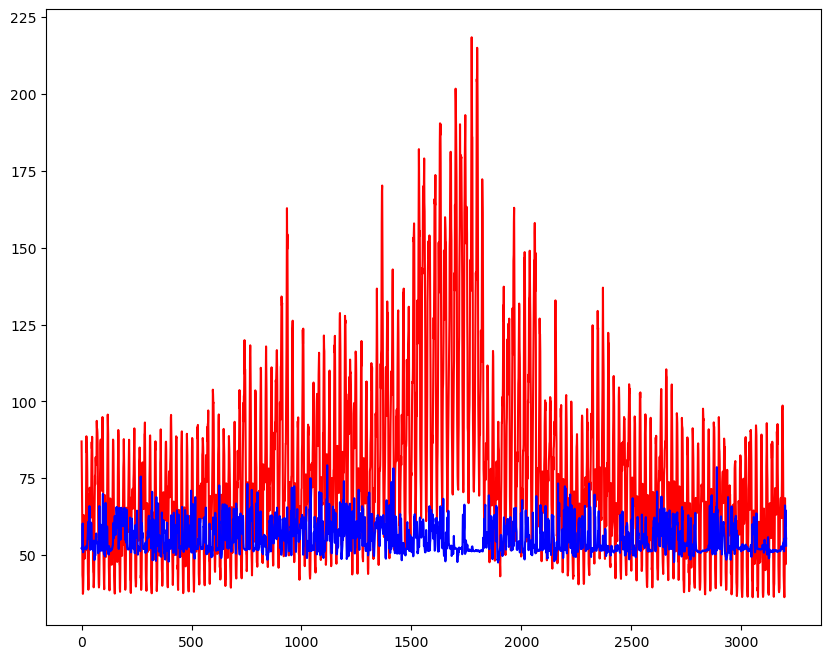

In [60]:
## Visualising the results
plt.plot(true, color='red')
plt.plot(pred, color='blue')
plt.show()

In [61]:
## Code Time
print('TIME : ', tm_code)

com_Analysis.model_sk_metrics(true, pred)

TIME :  122.40491032600403
MAE  :  26.105305605687203
MAPE :  0.2869003202800493
MSE  :  1379.6620403224629
RMSE :  37.14380217913162
MSLE :  0.19947368660403547
R2   :  -0.5776563470657317


In [62]:
print(str_domain)
print(str_interval)
print(str_col_tar)

ELEC
1WEEK
ELEC_INST_SUM_C0
